# Bastien GUILLOU, Ryan KHOU and Van-Minh Christophe LE

## Project objective:

This notebook retraces the development and fine-tuning process of a large language model (LLM) based on GPT-2, specially adapted to meet a precise daily need: automatic correction of spelling errors in texts. This fine-tuned model aims to improve the accuracy and effectiveness of French grammar correction in various contexts of daily communication. This project builds on the knowledge gained from the pre-training and fine-tuning sessions of Chapters 5, 6, and 7 and the Labs 6-7 to create a functional prototype that demonstrates how fine-instructiontuning can dramatically improve the model’s ability to follow user
commands and prompts.

# Phase 1: Environment Setup & Base Model Initialization

A pre-trained GPT-2 model with its hyper parameters is initialized and loaded, running on a CUDA device if available for more computational speed.

In [3]:
import tiktoken
import torch
from gpt_download import download_and_load_gpt2
from previous_labs import GPTModel, load_weights_into_gpt

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(model_size=model_size, models_dir="gpt2")

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval();

tokenizer = tiktoken.get_encoding("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 33.9kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 649kiB/s]
hparams.json: 100%|██████████| 91.0/91.0 [00:00<00:00, 37.2kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 1.42G/1.42G [08:24<00:00, 2.81MiB/s]
model.ckpt.index: 100%|██████████| 10.4k/10.4k [00:00<00:00, 6.17MiB/s]
model.ckpt.meta: 100%|██████████| 927k/927k [00:01<00:00, 562kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:01<00:00, 380kiB/s]


Check that the model is loaded correctly

In [4]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_f

# Phase 2: Instruction Dataset Preparation

We load a spell check dataset from Hugging Face, create instruction pairs to train our model from the data, and save those pairs in a JSON file for fine-tuned the model later. Finally, we display a sample of the pairs to check their format and content.

In [1]:
from datasets import load_dataset
import json

def create_instruction_pairs(entries):
    instruction_data = []
    for entry in entries:

        # Directly use the texts without encoding conversion
        input_text = entry['input']
        output_text = entry['target']

        # Prepare data for grammatical correction
        instruction_data.append({
            "instruction": "Corrigez le texte suivant.",
            "input": input_text,
            "output": output_text
        })

    return instruction_data

def save_data_to_json(instruction_data, file_path="correction-data.json"):
    # Save the instruction pairs
    with open(file_path, "w", encoding='utf8') as file:
        json.dump(instruction_data, file, ensure_ascii=False, indent=4)

dataset = load_dataset("fdemelo/spelling-correction-french-news")

# Creation of the instruction pairs
instruction_pairs = create_instruction_pairs(dataset['train'])

save_data_to_json(instruction_pairs)

# Display of a sample for verification
print(json.dumps(instruction_pairs[:2], ensure_ascii=False, indent=4))


[
    {
        "instruction": "Corrigez le texte suivant.",
        "input": "grammaire: 145 mille lénages vont en bénéficier.",
        "output": "145 mille ménages vont en bénéficier."
    },
    {
        "instruction": "Corrigez le texte suivant.",
        "input": "grammaire: 145 mille ménages vont enbénéficier.",
        "output": "145 mille ménages vont en bénéficier."
    }
]


Random typographical errors are introduced in the texts to increase the data set, while preserving the prefix "grammar:". This method generates several variants of a text to improve the robustness of the model during training. The augmented data is then recorded.

In [6]:
import json
import random

def introduce_errors(text):
    # Initialize constants and random operations
    prefix = "grammaire: "
    prefix_len = len(prefix)
    operations = ['delete', 'swap', 'insert']
    characters = 'abcdefghijklmnopqrstuvwxyz'
    new_text = list(text)
    num_errors = random.randint(1, 2)

    # Apply random grammatical errors to text
    for _ in range(num_errors):
        operation = random.choice(operations)
        index = random.randint(prefix_len, len(new_text) - 2)

        if operation == 'delete' and len(new_text) > prefix_len:
            new_text.pop(index)
        elif operation == 'swap' and index + 1 < len(new_text):
            new_text[index], new_text[index + 1] = new_text[index + 1], new_text[index]
        elif operation == 'insert':
            new_text.insert(index, random.choice(characters))

    return ''.join(new_text)

def augment_data(data, num_variants):
    # Generate multiple variants of the data with introduced errors
    augmented_data = []
    for item in data:
        original_input = item['input']
        augmented_data.append(item)
        for _ in range(1, num_variants):
            augmented_input = introduce_errors(original_input)
            augmented_item = {
                'instruction': item['instruction'],
                'input': augmented_input,
                'output': item['output']
            }
            augmented_data.append(augmented_item)
    return augmented_data

# Load original data
with open('correction-data.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

# Augment the data and create multiple variants of the sentence
augmented_data = augment_data(data, num_variants=5)

# Save the augmented data
with open('augmented-correction-data.json', 'w', encoding='utf-8') as file:
    json.dump(augmented_data, file, ensure_ascii=False, indent=4)

print("Augmented data saved successfully.")


Augmented data saved successfully.


We check the correct creation of our dataset increased by the number of existing intructions.

In [7]:
import json
import os
import urllib

def download_and_load_file(file_path, url):
  # Check if file exists, if not, download from URL and write to local file
    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf8")
        with open(file_path, "w", encoding="utf8") as file:
            file.write(text_data)
    # Try loading the file as JSON, handle exceptions for encoding issues
    try:
        with open(file_path, "r", encoding="utf8") as file:
            data = json.load(file)
    except UnicodeDecodeError as e:
        print(f"Error reading {file_path}: {e}")
        data = None
    return data

file_path = "augmented-correction-data.json"
url = ""

data = download_and_load_file(file_path, url)
# Output the number of entries or an error message
if data:
    print("Number of entries:", len(data))
else:
    print("Failed to load data due to encoding issues.")


Number of entries: 245560


Prepare the data batches for model training by adding an end of text token, adjusting sequence length to level out the batch, and managing the non-attention masks for completed sequences.

In [8]:
import torch

def custom_collate_fn(
    batch,
    pad_token_id=50256,
    ignore_index=-100,
    allowed_max_length=None,
    device="cpu"
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs and targets
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = new_item + [pad_token_id] * (batch_max_length - len(new_item))
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets

        # New: Replace all but the first padding tokens in targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index

        # New: Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs and targets to tensors and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)

    return inputs_tensor, targets_tensor

We prepare and tokenize the training data for our model, formatting with the Alpaca prompt style the entries and the associated responses for each instruction.

In [5]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [10]:
import torch
from torch.utils.data import Dataset


class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data

        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )

    def __getitem__(self, index):
        return self.encoded_texts[index]

    def __len__(self):
        return len(self.data)

We load our instruction dataset.

In [11]:
import time
import torch

from functools import partial
import tiktoken
from torch.utils.data import DataLoader

train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

tokenizer = tiktoken.get_encoding("gpt2")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

batch_size = 8
num_workers = 0

model.to(device)

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

# Phase 3: Instruction Fine-Tuning

Now we need to creat all the function to evaluate our model and monitor its performance

A function is used to evaluate the model’s performance on the training and validation data sets, calculating and returning losses for each set in order to adjust and improve the model.

In [12]:
from gpt_download import download_and_load_gpt2
from previous_labs import (
    calc_loss_loader,
    generate,
    GPTModel,
    load_weights_into_gpt,
    text_to_token_ids,
    train_model_simple,
    token_ids_to_text
)

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

The loss for a batch of data is calculated by comparing the predicted outputs from the model with the true target values, using the cross entropy loss function.

In [13]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

Reusing a function generates and displays an example of text from an initial context using a pre-trained template.

In [14]:
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
        decoded_text = token_ids_to_text(token_ids, tokenizer)
        print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (B, T) array of indices in the current context
    for _ in range(max_new_tokens):

        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]

        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)

        # Focus only on the last time step
        # (batch, n_token, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]

        # Get the idx of the vocab entry with the highest logits value
        idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

The learning function given in previous Lab is adapted to train a model using training and validation data, adjusting the learning rate and implementing a loss of validation based early stop to prevent overlearning.

In [15]:
import torch

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer, patience=5):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Scheduler for learning rate adjustment
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()  # Calculate loss gradients
            optimizer.step()  # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

                # Adjust learning rate based on the validation loss
                scheduler.step(val_loss)

                # Check for early stopping
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    epochs_no_improve = 0
                else:
                    epochs_no_improve += 1
                    if epochs_no_improve >= patience:
                        print(f'No improvement for {patience} evaluations, adjusting learning rate.')
                        break  # Break out of the loop, go to the next epoch

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


Now we can train our model and print its losss function on training and validation set.

Initial Training loss: 3.970228910446167
Initial Validation loss: 4.199329805374146
Ep 1 (Step 000000): Train loss 3.326, Val loss 3.592
Ep 1 (Step 000005): Train loss 2.268, Val loss 2.500
Ep 1 (Step 000010): Train loss 2.099, Val loss 2.212
Ep 1 (Step 000015): Train loss 1.988, Val loss 2.144
Ep 1 (Step 000020): Train loss 1.887, Val loss 2.105
Ep 1 (Step 000025): Train loss 1.959, Val loss 2.101
Ep 1 (Step 000030): Train loss 1.922, Val loss 2.074
Ep 1 (Step 000035): Train loss 1.873, Val loss 2.062
Ep 1 (Step 000040): Train loss 1.855, Val loss 2.057
Ep 1 (Step 000045): Train loss 1.894, Val loss 2.061
Ep 1 (Step 000050): Train loss 1.735, Val loss 2.081
Ep 1 (Step 000055): Train loss 1.801, Val loss 2.069
Ep 1 (Step 000060): Train loss 1.807, Val loss 2.046
Ep 1 (Step 000065): Train loss 1.837, Val loss 2.030
Ep 1 (Step 000070): Train loss 1.770, Val loss 2.020
Ep 1 (Step 000075): Train loss 1.820, Val loss 2.008
Ep 1 (Step 000080): Train loss 1.802, Val loss 1.998
Ep 1 (Step 0000

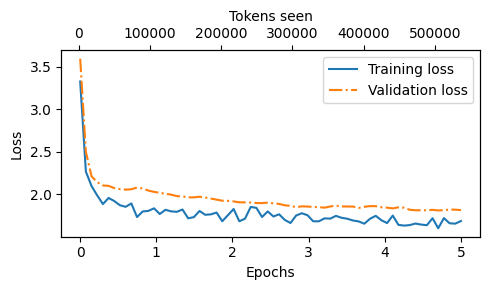

--------------------------------------------------
Model saved as saved_models/gpt2-medium355M-sft.pth


In [16]:
import torch
from previous_labs import calc_loss_loader, plot_losses
import time
import re

# Définir les paramètres initiaux
num_epochs = 5
optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)
eval_freq = 5
eval_iter = 5
patience = 4 # for early stopping

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Enregistrer les pertes initiales
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print(f"Initial Training loss: {train_loss}")
print(f"Initial Validation loss: {val_loss}")

# Boucle d'entraînement avec early stopping et suivi de la perte de validation
start_time = time.time()

# Adapter la fonction d'entraînement avec early stopping
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=eval_freq, eval_iter=eval_iter,
    start_context=format_input(val_data[0]), tokenizer=tokenizer, patience=patience
)

# Calculer la durée d'entraînement
end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

# Afficher les pertes sur les graphiques
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(
    epochs_tensor,
    tokens_seen,
    train_losses,
    val_losses
)
print(50*"-")

# Ensure the model directory exists or create it
model_directory = 'saved_models'
os.makedirs(model_directory, exist_ok=True)
file_name = os.path.join(model_directory, f"{re.sub(r'[ ()]', '', CHOOSE_MODEL) }-sft.pth")

# Save the model
torch.save(model.state_dict(), file_name)
print(f"Model saved as {file_name}")

# Phase 4: Evaluation & Iterative Improvement

We test our model on a set of test data based on instructions formatted in the Alpaca style, and display both the expected correct answers and those generated by the model.

In [23]:
torch.manual_seed(123)

model.eval();

for entry in test_data[:20]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Corrigez le texte suivant.

### Input:
grammaire: Prévu co§me un titre cross-lpay PS3/Vita, lSy 4a peutt-être souffert de ce développemteknt conoint.

Correct response:
>> Prévu comme un titre cross-play PS3/Vita, Sly 4 a peut-être souffert de ce développement conjoint.

Model response:
>> Prévu co§me un titre cross-play PS3/Vita, la Sy 4a peut-être souffert de ce développement conoint.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Corrigez le texte suivant.

### Input:
grammaire: Prévu co§me un titre cross-lpay PS3/Via, lSy 4a peutt-être souffert de ce développmeent conoint.

Correct response:
>> Prévu comme un titre cross-play PS3/Vita, Sly 4 a peut-être souffert de ce développement conjoint.

Model response:
>> Prévu co§me un titre cross-play PS3/

We test our model on custom instructions.

In [20]:
custom_input_data = [
    {
        "instruction": "Corrigez le texte suivant.",
        "input": "grammaire: 145 mille lénages vont en bénéicier.",
        "output": "145 mille ménages vont en bénéficier."
    },
    {
        "instruction": "Corrigez le texte suivant.",
        "input": "grammaire: J'ai bin mangé ce midi.",
        "output": "J'ai bien mangé ce midi."
    },
    {
        "instruction": "Corrigez le texte suivant.",
        "input": "grammaire: Un enfant est un jeunu êre humain en corus de développement et dépendant de ses parents ou d’autres adultes.",
        "output": "Un enfant est un jeune être humain en cours de développement et dépendant de ses parents ou d’autres adultes."
    },
    {
        "instruction": "Corrigez le texte suivant.",
        "input": "grammaire: j'écrit une frase avec une faute.",
        "output": "j'écrit une phrase avec une faute."
    },
]

for entry in custom_input_data[:20]:

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Corrigez le texte suivant.

### Input:
grammaire: 145 mille lénages vont en bénéicier.

Correct response:
>> 145 mille ménages vont en bénéficier.

Model response:
>> 145 mille lénages vont en bénéicier.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Corrigez le texte suivant.

### Input:
grammaire: J'ai bin mangé ce midi.

Correct response:
>> J'ai bien mangé ce miid.

Model response:
>> J'ai bin mangé ce midi.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Corrigez le texte suivant.

### Input:
grammaire: Un enfant est un jeunu êre humain en corus de développement et dépendant de ses parents ou d’autres adultes.

Correct response:
>> Un

We generate the model responses on our test data set, record these responses for an evaluation of the quality of the answers made by our model with Ollama.

In [ ]:
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data[:300]), total=len(test_data[:300])):

    input_text = format_input(entry)

    token_ids = generate(
        model=model,
        idx=text_to_token_ids(input_text, tokenizer).to(device),
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(token_ids, tokenizer)
    response_text = generated_text[len(input_text):].replace("### Response:", "").strip()

    test_data[i]["model_response"] = response_text

# Save the augmented data
with open('augmented-correction-data-with-response.json', 'w', encoding='utf-8') as file:
    json.dump(test_data[:300], file, ensure_ascii=False, indent=4)

In [8]:
import psutil

def check_if_running(process_name):
    running = False
    for proc in psutil.process_iter(["name"]):
        if process_name in proc.info["name"]:
            running = True
            break
    return running

ollama_running = check_if_running("ollama")

if not ollama_running:
    raise RuntimeError("Ollama not running. Launch ollama before proceeding.")
print("Ollama running:", check_if_running("ollama"))

Ollama running: True


In [9]:
import json
from tqdm import tqdm

file_path = "augmented-correction-data-with-response.json"

with open(file_path, "r") as file:
    test_data = json.load(file)

We send our queries to the llama3 model to get a response based on a specific prompt.

In [10]:
import urllib.request

def query_model(prompt, model="llama3", url="http://localhost:11434/api/chat"):
    # Create the data payload as a dictionary
    data = {
        "model": model,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {     # Settings below are required for deterministic responses
            "seed": 123,
            "temperature": 0,
            "num_ctx": 2048
        }
    }

    # Convert the dictionary to a JSON formatted string and encode it to bytes
    payload = json.dumps(data).encode("utf-8")

    # Create a request object, setting the method to POST and adding necessary headers
    request = urllib.request.Request(url, data=payload, method="POST")
    request.add_header("Content-Type", "application/json")

    # Send the request and capture the response
    response_data = ""
    with urllib.request.urlopen(request) as response:
        # Read and decode the response
        while True:
            line = response.readline().decode("utf-8")
            if not line:
                break
            response_json = json.loads(line)
            response_data += response_json["message"]["content"]

    return response_data


The quality of the responses provided is then assessed on the basis of the expected responses.

In [11]:
from tqdm import tqdm

def generate_model_scores(json_data, json_key, model="llama3"):
    scores = []
    for entry in tqdm(json_data, desc="Scoring entries"):
        if entry[json_key] == "":
            scores.append(0)
        else:
            prompt = (
                f"Given the input `{format_input(entry)}` "
                f"and correct output `{entry['output']}`, "
                f"score the model response `{entry[json_key]}`"
                f" on a scale from 0 to 100, where 100 is the best score. "
                f"Respond with the integer number only."
            )
            score = query_model(prompt, model)
            try:
                scores.append(int(score))
            except ValueError:
                print(f"Could not convert score: {score}")
                continue

    return scores

model = "llama3"
scores = generate_model_scores(test_data, "model_response", model="llama3")
print(f"Number of scores: {len(scores)} of {len(test_data)}")
print(f"Average score: {sum(scores)/len(scores):.2f}\n")


Scoring entries: 100%|██████████| 300/300 [11:55<00:00,  2.38s/it]

Number of scores: 300 of 300
Average score: 60.13



# Graphic Interface

In [6]:
import tkinter as tk
from tkinter import scrolledtext
import tiktoken
import torch
import tkinter as tk
from tkinter import scrolledtext
from previous_labs import GPTModel, load_weights_into_gpt

from previous_labs import (
    calc_loss_loader,
    generate,
    GPTModel,
    load_weights_into_gpt,
    text_to_token_ids,
    train_model_simple,
    token_ids_to_text
)

# Configuration for the GPT-2 model
BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0,
    "qkv_bias": True,
    "emb_dim": 1024,
    "n_layers": 24,
    "n_heads": 16
}

# Path to the fine-tuned model weights
model_path = "gpt2-medium355M-sft.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model
model = GPTModel(BASE_CONFIG)
model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()
model.to(device)

# Assume tiktoken is used for encoding/decoding tokens
tokenizer = tiktoken.get_encoding("gpt2")


def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

def correct_text(input_text):
    formatted_input = format_input({
        "instruction": "Corrigez le texte suivant.",
        "input": f"grammaire: {input_text}.",
        "output": ""
    })
    token_ids = text_to_token_ids(formatted_input, tokenizer).to(device)
    generated_token_ids = generate(
        model=model,
        idx=token_ids,
        max_new_tokens=256,
        context_size=BASE_CONFIG["context_length"],
        eos_id=50256
    )
    generated_text = token_ids_to_text(generated_token_ids, tokenizer)
    response_text = generated_text[len(formatted_input):].replace("### Response:", "").strip()
    return response_text

# GUI setup
root = tk.Tk()
root.title("Chat with Your LLM Model")
root.configure(bg='#202020')

# Chat history configuration
chat_history = scrolledtext.ScrolledText(root, state='disabled', height=20, width=70, bg='#333333', fg='white', padx=10, pady=10, font=('Arial', 12), wrap=tk.WORD)
chat_history.grid(row=0, column=0, columnspan=2, padx=20, pady=20)

chat_history.tag_configure('user', foreground='#88C0D0', background='#4C566A', justify='right', font=('Arial', 12, 'bold'))
chat_history.tag_configure('model', foreground='#ECEFF4', background='#434C5E', justify='left', font=('Arial', 12, 'italic'))

def send_message():
    user_input = text_entry.get("1.0", tk.END).strip()
    if user_input:
        chat_history.config(state='normal')
        chat_history.insert(tk.END, user_input + '\n', 'user')
        chat_history.config(state='disabled')
        text_entry.delete('1.0', tk.END)
        model_response = correct_text(user_input)
        chat_history.config(state='normal')
        chat_history.insert(tk.END, model_response + '\n', 'model')
        chat_history.config(state='disabled')
        chat_history.see(tk.END)

# Bind the enter key to the send_message function
root.bind('<Return>', send_message)

# Text entry configuration
text_entry = tk.Text(root, height=3, width=50, bg='#4C566A', fg='white', font=('Arial', 12))
text_entry.grid(row=1, column=0, padx=20, pady=10)

# Send button configuration
send_button = tk.Button(root, text="Send", command=send_message, bg='#5E81AC', fg='white', font=('Arial', 12, 'bold'))
send_button.grid(row=1, column=1, padx=10, pady=10)

root.mainloop()
